# S&SM
## L2. Alina Kragel, gr. 9

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import enum
from matplotlib import cycler
from functools import reduce
from scipy.special import comb
from scipy import stats
from math import gcd
from scipy.stats import norm, chi2

In [2]:
colors = cycler('color', ['#117A65', '#2D6C5F'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#2D6C5F')
plt.rc('lines', linewidth=2)

##### Подготовительный этап
Генераторы прошлой лабы.

In [3]:
class LCG:
    def __init__(self, x0, a, c, M):        
        self.a = a
        self.c = c
        self.M = M
        self.x = x0
    
    def __call__(self):
        self.x = (self.x * self.a + self.c) % self.M
        return self.x / self.M
    
    def get_period(self):
        s = list()
        while True:
            x = self()
            if x in s:
                break   
            s.append(x)
        return len(s)

In [4]:
class MMG:
    def __init__(self, g1, g2, k):
        assert k > 0
        self.k = k
        self.g1 = g1
        self.g2 = g2
        self.v = [g1() for _ in range(k)]
    
    def rand(self):
        s = int(self.g2() * self.k)
        rx = self.v[s]
        self.v[s] = self.g1()
        return rx

##### Параметры генераторов
LCG2: x0 = 2 ** 8, a = 75, c = 74, M = 2 ** 16 + 1\
LCG3: x0 = 2 ** 12, a = 1 140 671 485, c = 12 820 163, M = 2 ** 24\
MMG: LCG3, LCG2, k = 100

In [5]:
MMG = MMG(LCG(2 ** 12, 1_140_671_485, 12_820_163, 2 ** 24), LCG(2 ** 8, 75, 74, 2 ** 16 + 1), 100)

Оценка МО

In [6]:
def get_expectation(val):
    e_obs = 0
    for x in val:
        e_obs += x 
    e_obs /= len(val)
    return e_obs

Оценка Дисперсии

In [7]:
def get_dispersion(val):
    d = 0
    mean = 0
    for x in val:
        mean += x
    mean /= len(val)
    for x in val:
        d += (x - mean)**2
    d /= (len(val) - 1)
    return d

Хи-Квадрат

In [8]:
def chisquare(frec_obs, frec_exp):
    chisquare = 0.0
    for i in range(len(frec_obs)):
        chisquare += ((frec_obs[i] - frec_exp[i])**2 / frec_exp[i])
    return chisquare

Длина и уровень значимости

In [9]:
n = 1000
eps = 0.05

#### Отрицательное биномиальное распределение
##### Получаем случайное число через свой генератор по заданному распределению

In [10]:
def genDRV_bin(m, p):
    q = 1 - p
    p = p**m

    r = MMG.rand() - p
    
    z = 0
    while(r >= 0):
        z += 1
        p = p * q * ((m - 1 + z) / z)
        r -= p
    
    return z

##### Выборка заданного распределения через встроенный генератор

In [11]:
def p_binom(x, r, p):
    if (x < 0):
        return 0
    else:
        return comb(x + r - 1, x)*(p**r)*((1-p)**x)

In [12]:
# пределы гистограммы от 0 до 2*E, считаем ожидаемые частоты попадания в каждую область гистограммы
def exp_frec_binom(r, p):
    lim = 2 * math.floor(r * (1 - p) / p)
    frec_exp = []
    p_sum = 0

    for i in range(lim):
        _p = p_binom(i, r, p)
        p_sum += _p
        frec_exp.append(_p * n)
    
    frec_exp.append(n * (1 - p_sum))
    return frec_exp

In [13]:
# считаем выборочные частоты попадания в области гистограммы
def obs_frec_binom(val_obs, r, p):
    lim = 2 * math.floor(r * (1 - p) / p)
    f_obs = []
    for i in range(lim + 1):
        f_obs.append(0)
    
    val_sorted = sorted(val_obs)
    for val in val_sorted:
        if(val < lim):
            f_obs[val] += 1
        else:
            f_obs[lim] += 1
        
    return f_obs

In [14]:
r = 8
p = 0.4

In [15]:
val = list()
for i in range(n):
    val.append(genDRV_bin(r, p))

In [16]:
e_obs = get_expectation(val)
d_obs = get_dispersion(val)

In [17]:
# для отрицательно биномиального распределения матожидание равно (r*q) / p
# для отрицательно биномиального распределения дисперсия равна (r*q) / (p^2)
e_exp = r * (1 - p) / p
d_exp = r * (1 - p) / (p**2) 

In [18]:
frec_exp = exp_frec_binom(r, p)
frec_obs = obs_frec_binom(val, r, p)

In [19]:
k = len(frec_exp) - 1
delta = stats.chi2(k - 1).ppf(1 - eps)

In [20]:
print('E_exp = ' + format(e_exp, '.2f'))
print('E_obs = ' + format(e_obs, '.2f'))
print('D_exp = ' + format(d_exp, '.2f'))
print('D_obs = ' + format(d_obs, '.2f'))
print('Chisq = ' + format(chisquare(frec_obs, frec_exp), '.2f'))
print('Pass = ', chisquare(frec_obs, frec_exp) < delta)

E_exp = 12.00
E_obs = 12.14
D_exp = 30.00
D_obs = 31.33
Chisq = 34.14
Pass =  False


In [21]:
X_val = range(2 * math.floor(r * (1 - p) / p) + 1)
X, Ye, Yo = np.array(X_val), np.array(frec_exp), np.array(frec_obs)

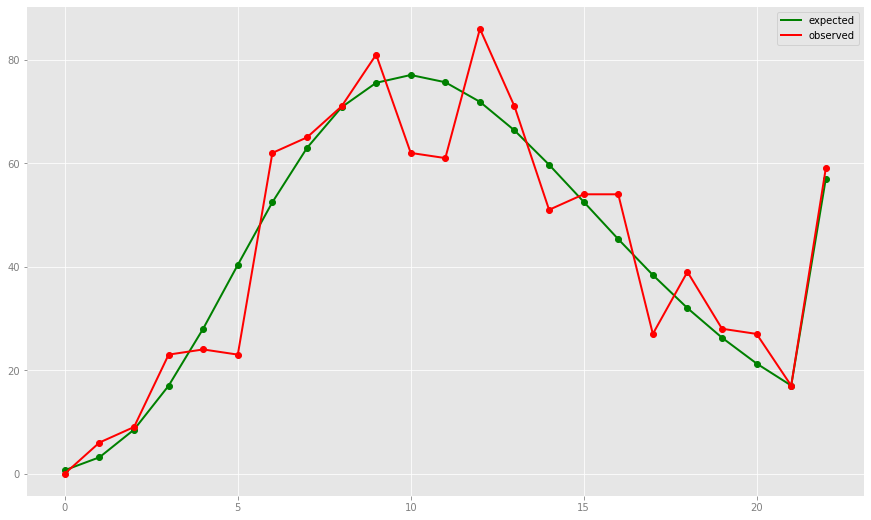

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(X, Ye, 'go')
plt.plot(X, Ye, 'g-', label = 'expected')
plt.plot(X, Yo, 'ro')
plt.plot(X, Yo, 'r-', label = 'observed')
plt.legend()
plt.show()

#### Геометрическое распределение

In [23]:
def genDRV_geom(p):
    a = MMG.rand()
    return math.floor(math.log(a) / math.log(1 - p)) + 1

In [24]:
def p_geom(x, p=0.25):
    if (x < 1):
        return 0
    else:
        return p * ((1 - p)**(x - 1))

In [25]:
lim = math.floor(6/p)

In [26]:
# пределы гистограммы от 1 до lim, считаем ожидаемые частоты попадания в каждую область гистограммы
def exp_frec_geom(p=0.25):
    frec_exp = []
    p_sum = 0

    for i in range(1, lim):
        _p = p_geom(i)
        p_sum += _p
        frec_exp.append(_p * n)
    
    frec_exp.append(n * (1 - p_sum))
    return frec_exp

In [27]:
# считаем выборочные частоты попадания в области гистограммы
def obs_frec_geom(val_obs, p=0.25):
    f_obs = []
    for i in range(1, lim + 1):
        f_obs.append(0)
    
    # calculate observed frequences
    val_sorted = sorted(val_obs)
    for val in val_sorted:
        if(val < lim):
            f_obs[val - 1] += 1
        else:
            f_obs[lim - 1] += 1
        
    return f_obs

In [28]:
p = 0.25

In [29]:
val = list()
for i in range(n):
    val.append(genDRV_geom(p))

In [30]:
# найдем оценки матожидания и дисперсии по сгенерированной выборке
e_obs = get_expectation(val)
d_obs = get_dispersion(val)

In [31]:
# для геометрического распределения матожидание равно 1 / p 
# для геометрического распределения дисперсия равна q / (p**2) 
e_exp = 1 / p
d_exp = (1 - p) / (p**2)

In [32]:
frec_exp = exp_frec_geom()
frec_obs = obs_frec_geom(val)

In [33]:
k = len(frec_exp) - 1
delta = stats.chi2(k - 1).ppf(1 - eps)

In [34]:
print('E_exp = ' + format(e_exp, '.2f'))
print('E_obs = ' + format(e_obs, '.2f'))
print('D_exp = ' + format(d_exp, '.2f'))
print('D_obs = ' + format(d_obs, '.2f'))
print('Chisq = ' + format(chisquare(frec_obs, frec_exp), '.2f'))
print('Pass = ', chisquare(frec_obs, frec_exp) < delta)

E_exp = 4.00
E_obs = 4.04
D_exp = 12.00
D_obs = 12.28
Chisq = 17.47
Pass =  True


In [35]:
X_val = range(1, lim + 1)
X, Ye, Yo = np.array(X_val), np.array(frec_exp), np.array(frec_obs)

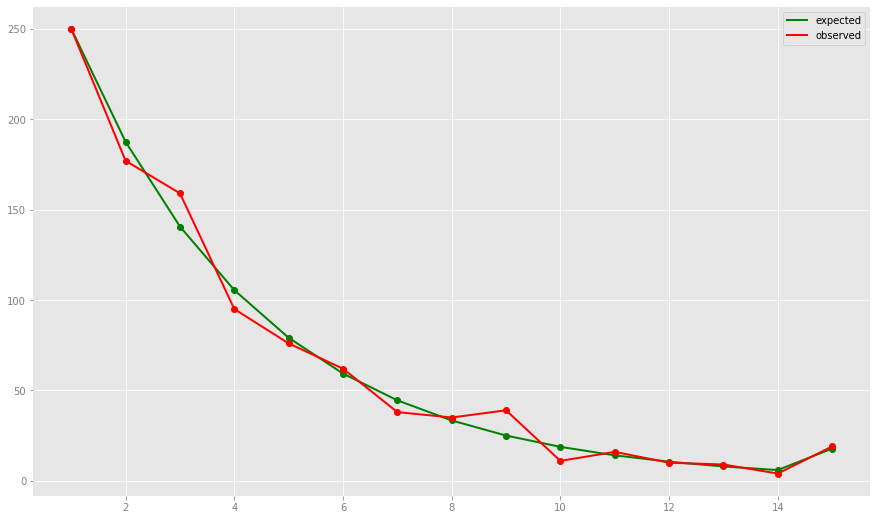

In [36]:
plt.figure(figsize=(15, 9))
plt.plot(X, Ye, 'go')
plt.plot(X, Ye, 'g-', label = 'expected')
plt.plot(X, Yo, 'ro')
plt.plot(X, Yo, 'r-', label = 'observed')
plt.legend()
plt.show()

#### Распределение Пуассона

In [37]:
def genDRV_puas(l):
    p = math.exp(-1 * l)
    r = MMG.rand() - p
    x = 0
    while(r >= 0):
        x += 1
        p = (p * l) / x
        r -= p
    return x

In [38]:
# РАСПРЕДЕЛЕНИЕ ПУАССОНА 

def p_puas(x, l=3):
    if (x < 0):
        return 0
    else:
        return math.exp(-1 * l) * (l**x) / math.factorial(x)

In [39]:
def exp_frec_puas(l=3):
    frec_exp = []
    p_sum = 0

    for i in range(2*l + 1):
        p = p_puas(i)
        p_sum += p
        frec_exp.append(p * n)
    
    frec_exp.append(n * (1 - p_sum))
    return frec_exp

In [40]:
def obs_frec_puas(val_obs, l=3):
    f_obs = []
    for i in range(2*l + 2):
        f_obs.append(0)
    
    val_sorted = sorted(val_obs)
    for val in val_sorted:
        if(val <= 2*l):
            f_obs[val] += 1
        else:
            f_obs[2*l + 1] += 1
        
    return f_obs

In [41]:
l = 3

In [42]:
val = list()
for i in range(n):
    val.append(genDRV_puas(l))

In [43]:
# найдем оценки матожидания и дисперсии по сгенерированной выборке
e_obs = get_expectation(val)
d_obs = get_dispersion(val)

In [44]:
# для распределения Пуассона матожидание и дисперсия совпадают со значением l 
e_exp = l
d_exp = l

In [45]:
frec_exp = exp_frec_puas()
frec_obs = obs_frec_puas(val)

In [46]:
k = len(frec_exp) - 1
delta = stats.chi2(k - 1).ppf(1 - eps)

In [47]:
print('E_exp = ' + format(e_exp, '.2f'))
print('E_obs = ' + format(e_obs, '.2f'))
print('D_exp = ' + format(d_exp, '.2f'))
print('D_obs = ' + format(d_obs, '.2f'))
print('Chisq = ' + format(chisquare(frec_obs, frec_exp), '.2f'))
print('Pass = ', chisquare(frec_obs, frec_exp) < delta)

E_exp = 3.00
E_obs = 2.88
D_exp = 3.00
D_obs = 2.70
Chisq = 8.25
Pass =  True


In [48]:
X_val = range(2*l + 2)
X, Ye, Yo = np.array(X_val), np.array(frec_exp), np.array(frec_obs)

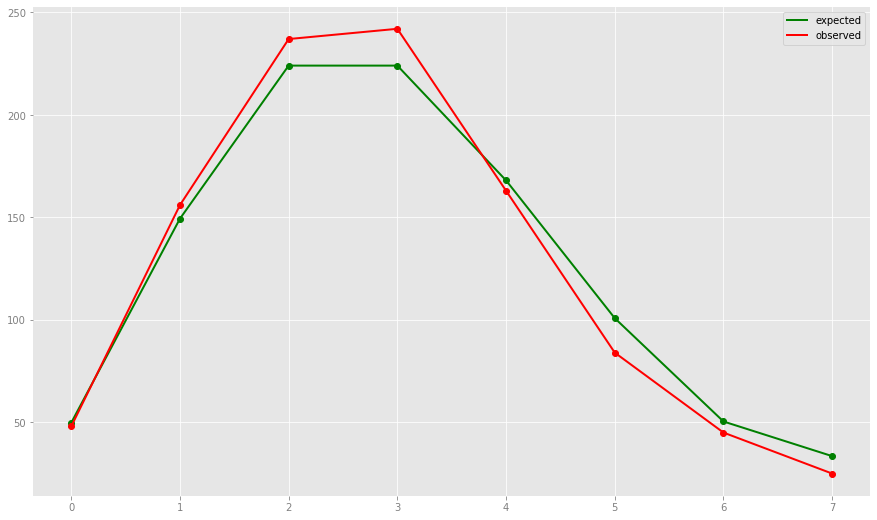

In [49]:
plt.figure(figsize=(15, 9))
plt.plot(X, Ye, 'go')
plt.plot(X, Ye, 'g-', label = 'expected')
plt.plot(X, Yo, 'ro')
plt.plot(X, Yo, 'r-', label = 'observed')
plt.legend()
plt.show()